In [73]:
import numpy as np
import pandas as pd
import segyio
import las
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib
import matplotlib.patches as mpatches

import os.path
from tqdm.notebook import tqdm

%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')


In [7]:
sourcefile=r"C:\Users\koushb\OneDrive - Husky Energy\ML\\ML_SI_Data\Tucker\PP.segy"
welllocations=r"C:\Users\koushb\OneDrive - Husky Energy\ML\ML_SI_Data\Tucker\wells\WellHeadLocations.txt"
lasfolder='C:/Users/koushb/OneDrive - Husky Energy/ML/ML_SI_Data/Tucker/wells/'


def getminmax(sourcefile):
    src=segyio.open(sourcefile)
    xmin=np.inf
    xmax=0
    ymin=np.inf
    ymax=0
    for i in range(src.tracecount):    
        tmp=src.header[i]
        t=tmp[segyio.TraceField.SourceX]
        if  t<xmin:
            xmin=t
        if  t>xmax:
            xmax=t
        
        t=tmp[segyio.TraceField.SourceY]
        if  t<ymin:
            ymin=t
        if  t>ymax:
            ymax=t
        
    src.close()
    return(xmin,xmax,ymin,ymax)


In [20]:
BBox=getminmax(sourcefile)
#print(BBox)
divisor=100
BBox = [x/divisor for x in BBox]

#print(BBox)

names=["Name","UWI","Well symbol","Surface X","Surface Y","Latitude","Longitude","Well datum name","Well datum value","Well datum description","TD (MD)","Cost","Spud date","Simulation name","Simulation export date","Operator","TWT auto","Uncertainty ground level","Uncertainty radius","Uncertainty standard deviation factor","FLOAT,GL","DATE,RR Date","FLOAT,Zones (hierarchy)","FLOAT,Status","STRING,well_id","FLOAT,KB","FLOAT,user1","FLOAT,pad","FLOAT,wellname","FLOAT,ground","FLOAT,Continuous1","FLOAT,Continuous2","FLOAT,Continuous3","Drilling structure","FLOAT,Ambient temperature","FLOAT,Heat transfer coefficient","Bottom hole X","Bottom hole Y"]
df=pd.read_table(welllocations,skiprows=47,delim_whitespace=True,names=names)

logs_names=['SP','ResD','Vshl']
#print(df.shape)

well_names=[]
logs=[]
for w in tqdm(df['UWI']):
   
    well=df[df.UWI==w]
    if well.empty:
        continue
    
    lasfile=lasfolder+w+'.las'
    if not os.path.isfile(lasfile):
        continue
    log=las.LASReader(lasfile)
    if len(log.data)==0:
        continue
    
    x=well['Surface X'].values[0]
    y=well['Surface Y'].values[0]
    #print(x,y)
    if  x >BBox[0] and x<BBox[1] and y>BBox[2] and y<BBox[3]:
        #print(w)
        well_names.append(w)
        log=pd.DataFrame(log.data)
        logs.append(log)

In [90]:
def on_wells_change(change): 
    well=wells.value
    indx=wells.index
    print(well)
    print(indx)
    
    log=logs[indx]
    
    indx_w=wells.index
    wellname=wells.value

    log=logs[indx_w]
    log[log==-999.25]=np.nan 
    
    plt.clf()
    
    fs=log['Faceis_ClearWater_vshl'].values
    fs=np.nan_to_num(fs,nan=-1)


#    colors={-1:'g',0:'g',1:'r',2:'y',3:'b'}    
#    c_facies=[]
#    for i in fs:
#        c_facies.append(colors[i])
#
#    plt.barh(-log["DEPT"],c_facies,align='center',color=c_facies, ecolor='black')
#    sand_patch = mpatches.Patch(color='g', label='sand')
#    shale_patch = mpatches.Patch(color='r', label='shale')
#    interbed_patch = mpatches.Patch(color='y', label='interbed')
#    plt.legend(handles=[sand_patch,shale_patch,interbed_patch])
    plt.plot(fs,-log["DEPT"])
    

    
                     

Dropdown(description='Well UWI', options=('100012806404W400', '100023206404W400', '100032806404W400', '1000421…

100012806404W400
0


<IPython.core.display.Javascript object>


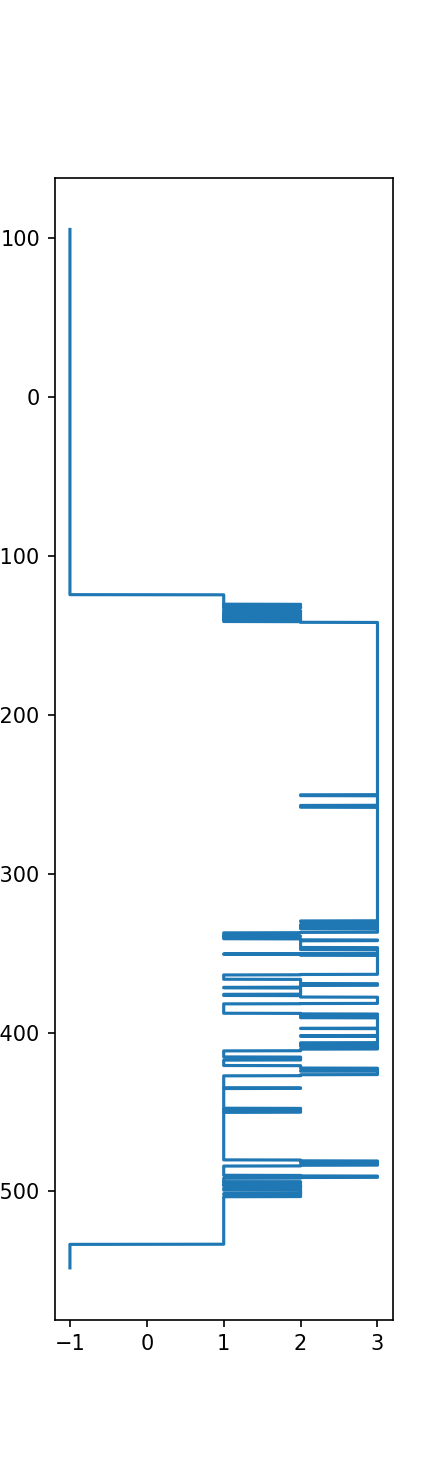

In [91]:
wells=widgets.Dropdown(options=well_names,description='Well UWI',disabled=False,style={'description_width': 'initial'})
target='Faceis_ClearWater_vshl'
wells.observe(on_wells_change,names=['value'])

display(wells)
on_wells_change(None)